In [10]:
import csv
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
%run Pipeline//classify_and_evaluate
%run Pipeline//upload_and_vizualize
%run Pipeline//aux
import pylab as pl
import seaborn as sn
from datetime import datetime as dt
from datetime import date 
import geopandas as gpd


In [2]:
cal = pd.read_csv('data/calendar_chicago_2015.csv')
cal_copy = cal.copy()

In [3]:
cal.head()

,listing_id,date,available,price
0,14831696,2018-04-01,f,NaN
1,14831696,2018-03-31,f,NaN
2,14831696,2018-03-30,f,NaN
3,14831696,2018-03-29,f,NaN
4,14831696,2018-03-28,f,NaN


In [5]:
cal.transpose().head()

,0,1,2,3,4,5,6,7,8,9,...,5541785,5541786,5541787,5541788,5541789,5541790,5541791,5541792,5541793,5541794
listing_id,14831696,14831696,14831696,14831696,14831696,14831696,14831696,14831696,14831696,14831696,...,17634195,17634195,17634195,17634195,17634195,17634195,17634195,17634195,17634195,17634195
date,2018-04-01,2018-03-31,2018-03-30,2018-03-29,2018-03-28,2018-03-27,2018-03-26,2018-03-25,2018-03-24,2018-03-23,...,2017-04-11,2017-04-10,2017-04-09,2017-04-08,2017-04-07,2017-04-06,2017-04-05,2017-04-04,2017-04-03,2017-04-02
available,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f
price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
cal.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [7]:
dprint(dt.strptime(cal.loc[1].date,'%Y-%m-%d'))

2018-03-31 00:00:00


In [3]:
def convert_to_datetime(series_row):
    return dt.strptime(series_row,'%Y-%m-%d')

def convert_to_weekday(series_row,output):
    if output == 'day_num':
        return date.weekday(series_row)
    output_dict = {"weekday":'%A', "month_name":'%B',"month_num":'%m'}
    return date.strftime(series_row,output_dict[output])

def convert_to_bool(df, column, conversion):
    return df[column].replace(conversion)

def add_date_cols(df, date_column):
    df['datetime'] = df[date_column].apply(convert_to_datetime)
    df['day_num'] = df.datetime.apply(convert_to_weekday, output='day_num')
    df['day_of_week'] = df.datetime.apply(convert_to_weekday, output='weekday')
    df['month'] =  df.datetime.apply(convert_to_weekday, output='month_name')
    df['month_num'] =  df.datetime.apply(convert_to_weekday, output='month_num')

In [5]:
def get_occupied_frame(df, occ_column, date_column, conversion, bool_param):
    add_date_cols(df,date_column)
    df[occ_column] = convert_to_bool(df,occ_column,conversion)
    return df[df[occ_column] == bool_param]

In [6]:
d = {'t': True, 'f': False}
cal_occupied = get_occupied_frame(cal,'available','date', d, True)

In [191]:
cal_occupied.count()

listing_id     1260635
date           1260635
available      1260635
price          1260635
datetime       1260635
day_num        1260635
day_of_week    1260635
month          1260635
month_num      1260635
dtype: int64

In [214]:
cal_occupied.dtypes

listing_id              int64
date                   object
available                bool
price                  object
datetime       datetime64[ns]
day_num                 int64
day_of_week            object
month                  object
month_num              object
dtype: object

/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


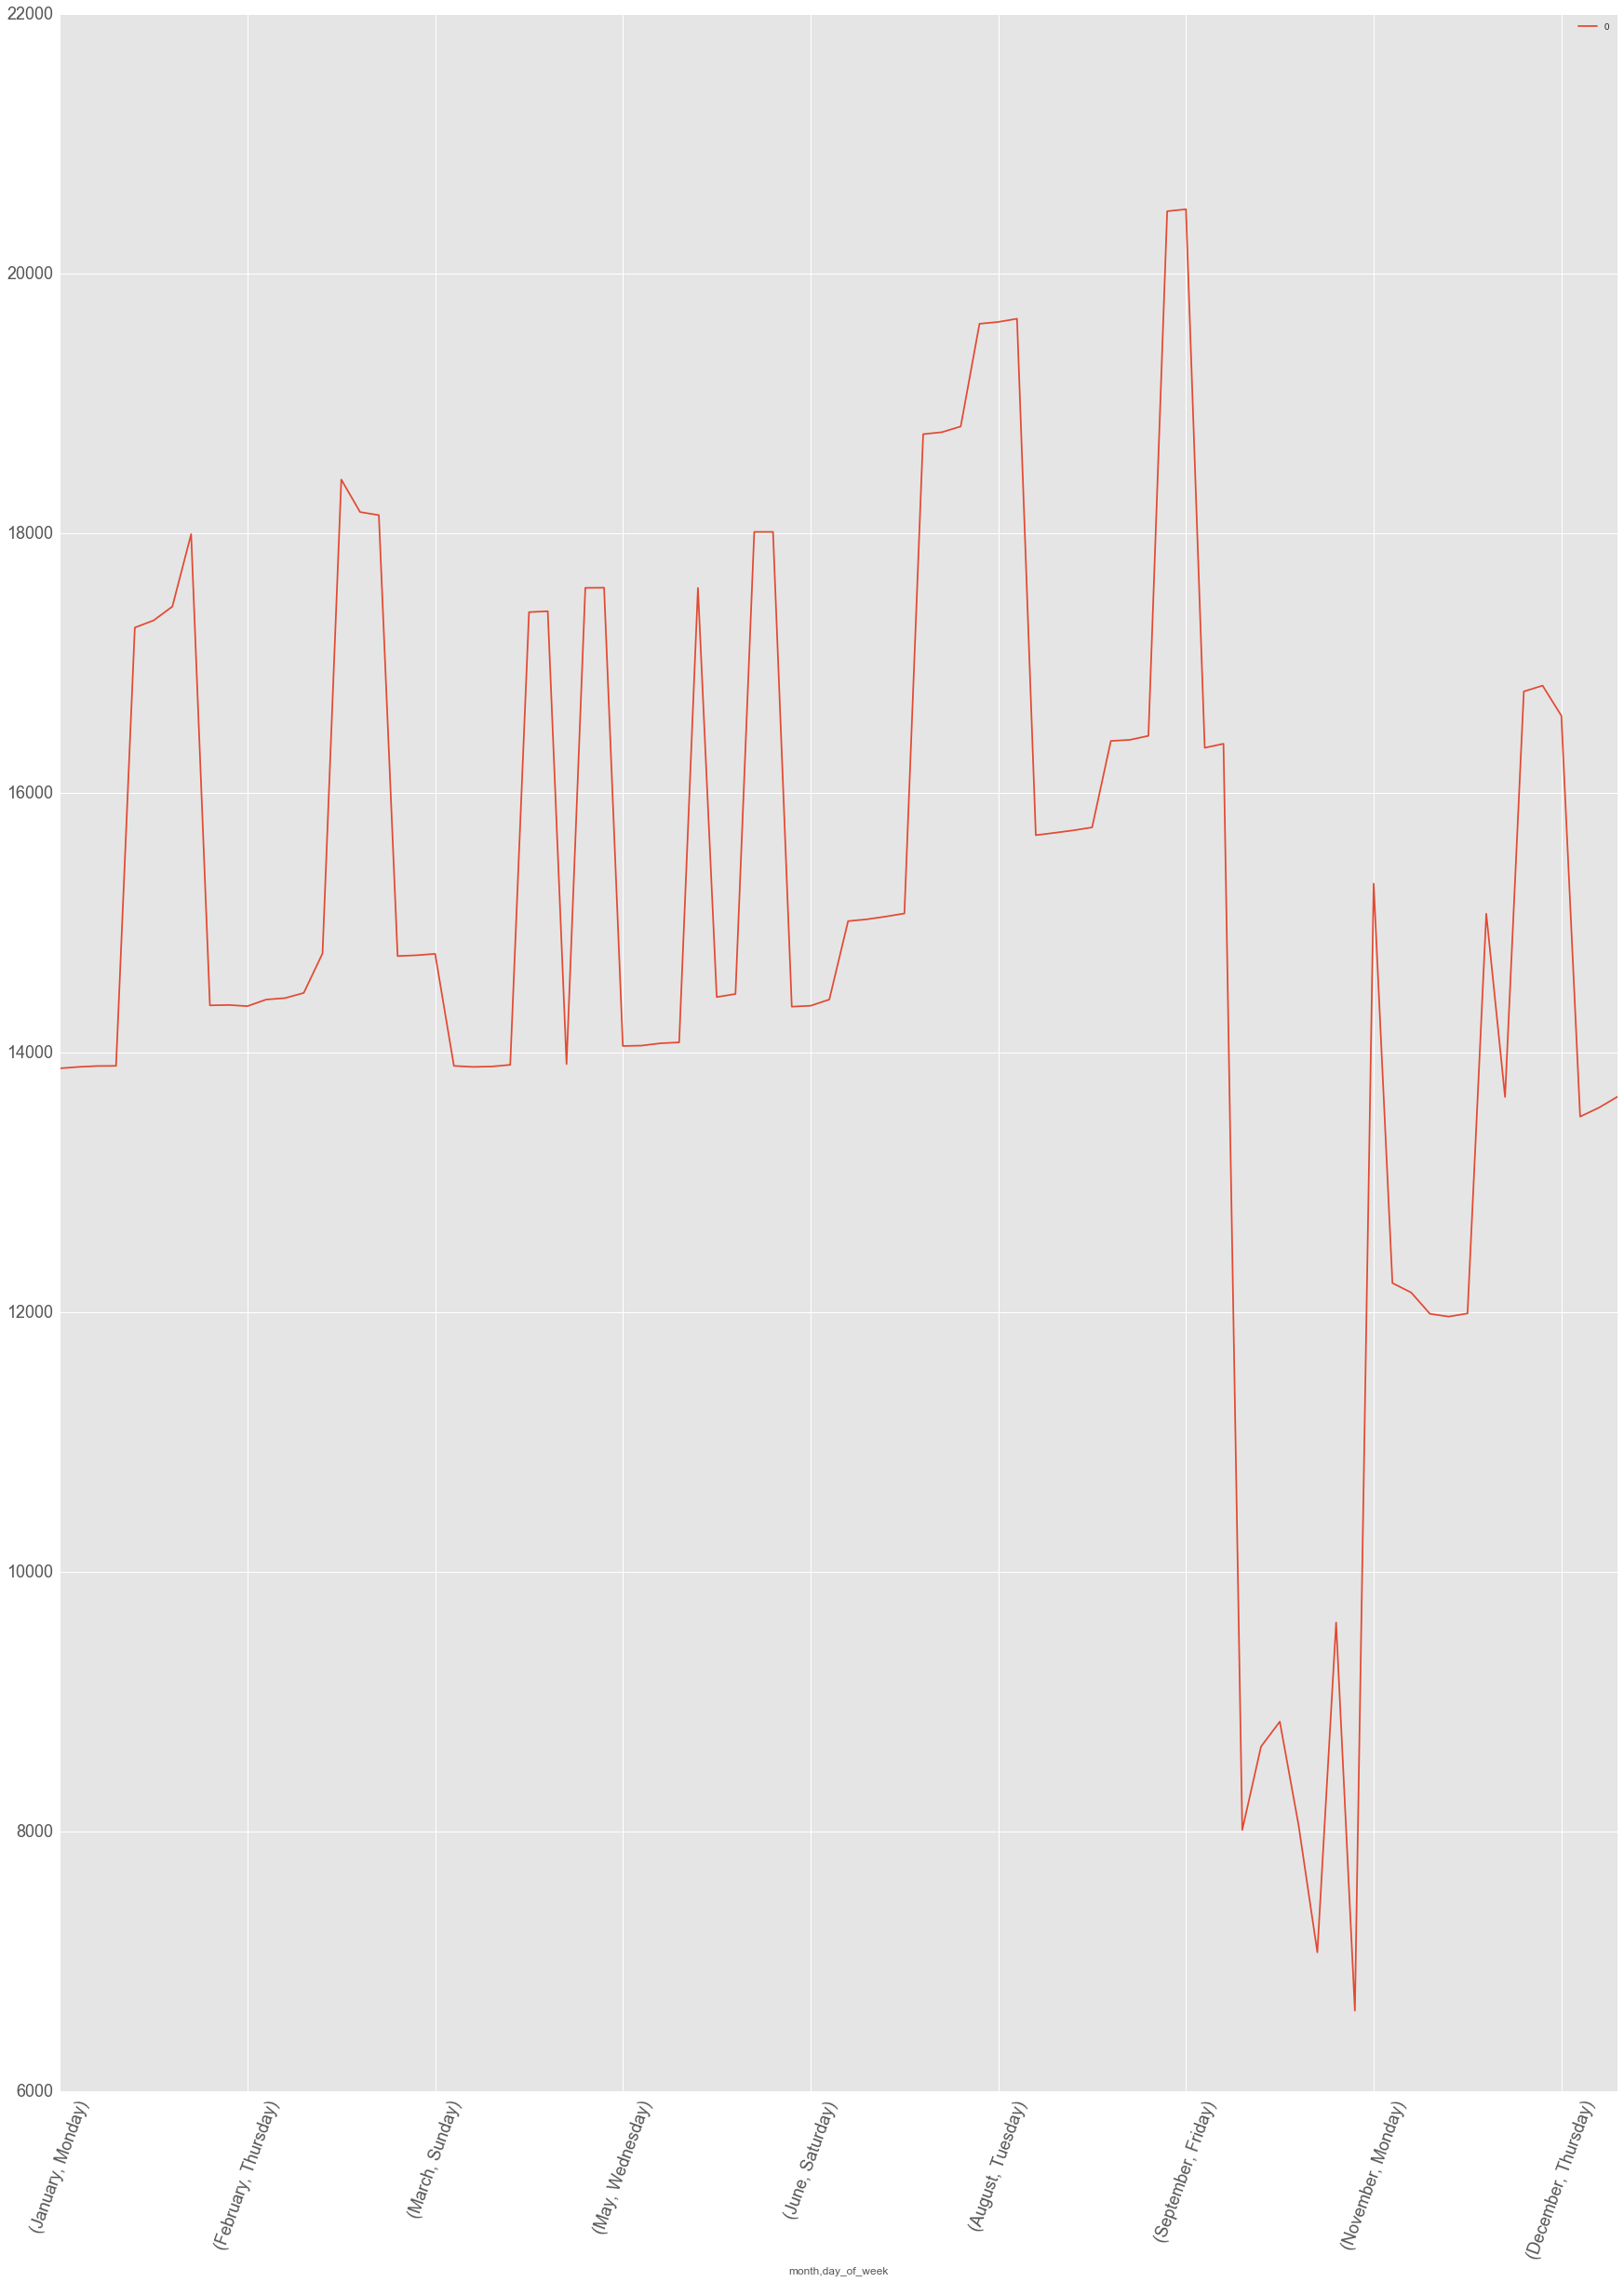

In [6]:

cal_unavailable_monthXDay = cal_occupied.sort(['month_num','day_num']).groupby(['month','day_of_week'], sort=False).size().to_frame()

cal_unavailable_monthXDay.plot(kind='line',figsize=(30,40), fontsize=18,rot=70)

month_num index     01                                               02  \
day_num              0      1      2      3      4      5      6      0   
0             0  13882  13893  13900  13901  17277  17332  17439  17997   

month_num         ...       11                   12                       \
day_num        1  ...        4      5      6      0      1      2      3   
0          14367  ...    11970  11994  15073  13661  16785  16830  16598   

month_num                       
day_num        4      5      6  
0          13510  13579  13664  

[1 rows x 85 columns]

By listing_id and month, count of occupied, and sum

In [ ]:

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name,i in cal_occupied.sort('month_num').groupby(['listing_id','month'],sort=False):#.available.count().to_frame():#.plot(kind='scatter')
    fig, ax = plt.subplots()
    print(name,i)
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    ax.plot(i[0], i[1], marker='o', linestyle='', ms=12)

In [39]:
small = chicago_listing[['id','price']]

def convert_to_float(series_row):
    return float(series_row.replace('$','').replace(',',''))

#small['priceNo$'] = small.price.apply(convert_to_float)
small.head()

,id,price
0,1874928,142
1,739495,120
2,1696051,85
3,5152597,125
4,8036094,75


In [40]:
listing = []
avg_price = []
for index, i in enumerate(small.groupby('id').mean().iterrows()):#.available.count().to_frame():#.plot(kind='scatter')
    listing.append(i[0])
    avg_price.append(i[1][0])

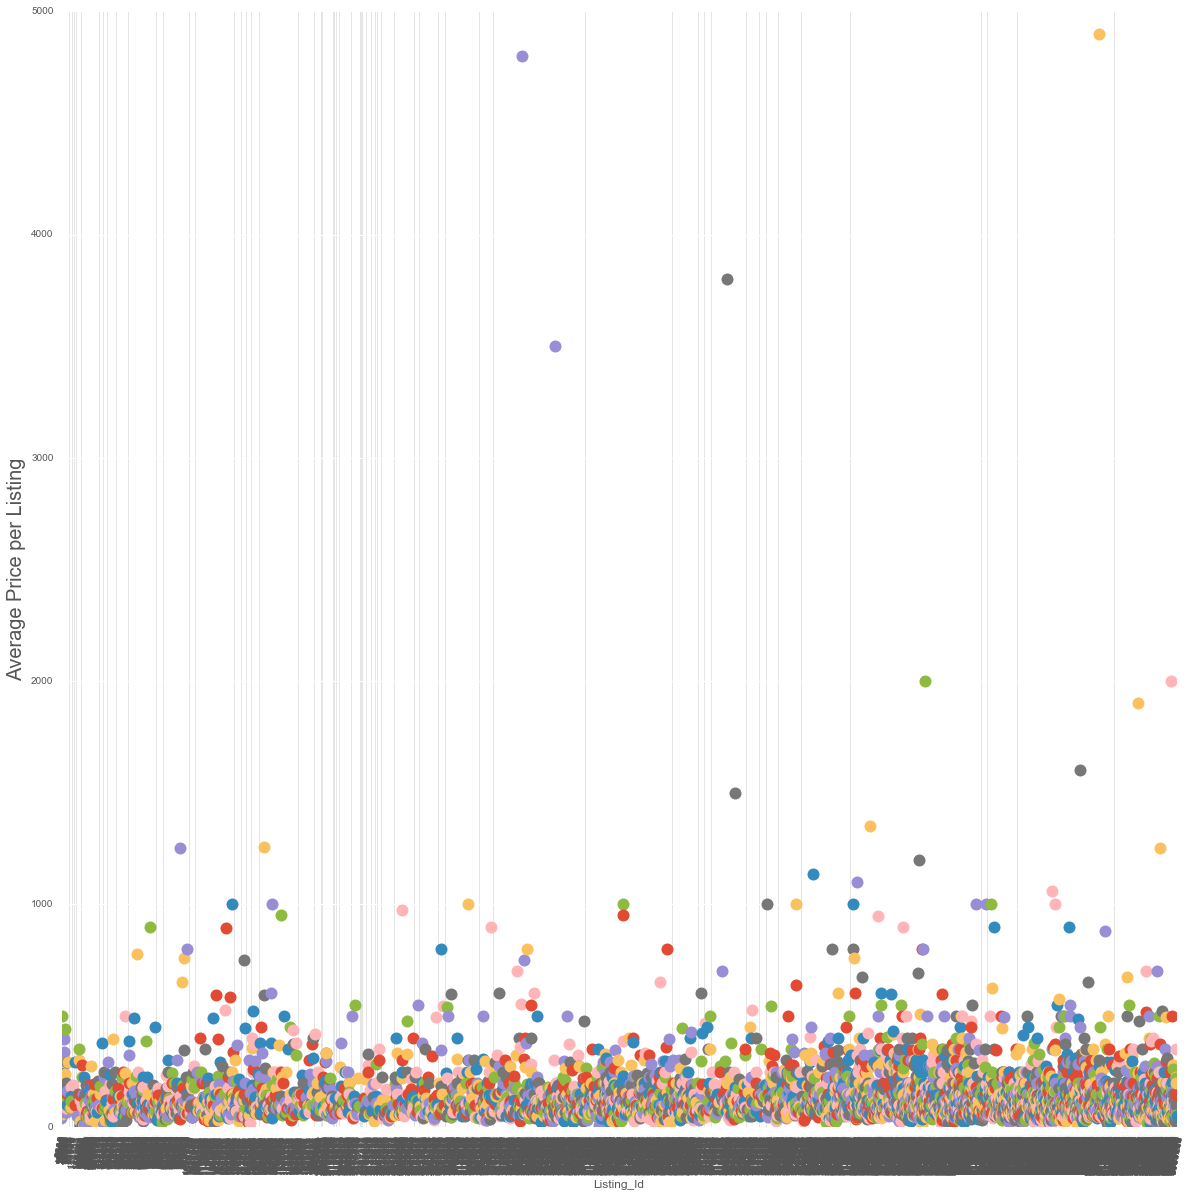

In [42]:
fig = plt.figure(figsize=(20,20))
plt.xticks(listing, listing, rotation=80)
ax = fig.add_subplot(1,1,1)
#ax.xticks(listing,None,rotation='vertical')
ax.set_ylabel('Average Price per Listing', fontsize=20)
ax.set_xlabel('Listing_Id', fontsize=12)
for index, i in enumerate(small.groupby('id').mean().iterrows()):#.available.count().to_frame():#.plot(kind='scatter')
    ax.plot(i[0], i[1], marker='o', linestyle='', ms=12)


(0, 1500)

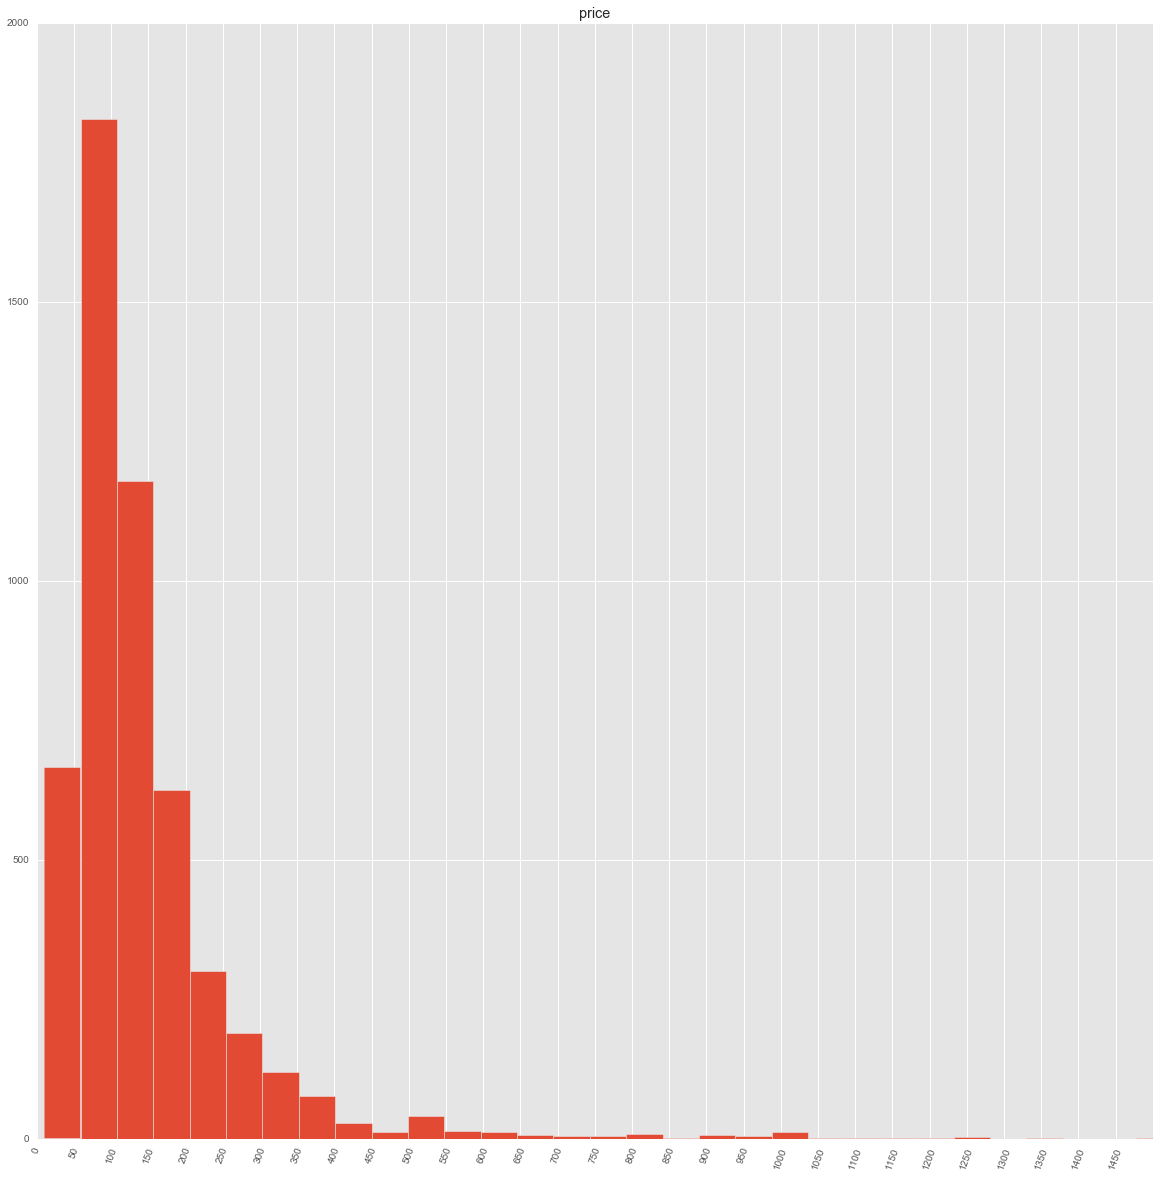

In [44]:
small.groupby('id').mean().hist(bins=100, figsize=(20,20))
plt.xticks(range(0,1500,50), rotation=70)
plt.xlim(0,1500,25)


In [13]:
chicago_listing = read_file('data/chicago_listings.csv')

In [22]:
all_cols, all_cols_caps, pt_columns = list_describe(chicago_listing)

                 id
count  5.147000e+03
mean   5.408046e+06
std    2.519789e+06
min    2.384000e+03
25%    3.632306e+06
50%    6.200526e+06
75%    7.558910e+06
max    8.689532e+06 

                                     name
count                                5147
unique                               5098
top     Private Room with Shared Bathroom
freq                                    4 

            host_id
count  5.147000e+03
mean   1.779156e+07
std    1.422345e+07
min    3.040000e+02
25%    4.487353e+06
50%    1.472736e+07
75%    3.062774e+07
max    4.560581e+07 

       host_name
count       5109
unique      1795
top        David
freq          60 

       neighbourhood_group
count                  0.0
mean                   NaN
std                    NaN
min                    NaN
25%                    NaN
50%                    NaN
75%                    NaN
max                    NaN 

       neighbourhood
count           5147
unique            69
top        West Town
freq    

/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


/Users/andrewyaspan/Documents/ml_project/ML_Project/Pipeline/upload_and_vizualize.py:131: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  df.boxplot(column=column_name, ax = ax2); ax2.set_title('Boxplot of '+column_name)


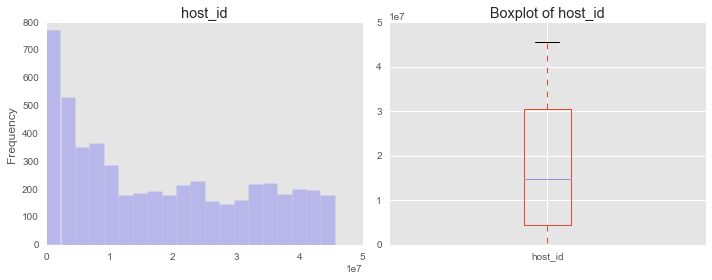

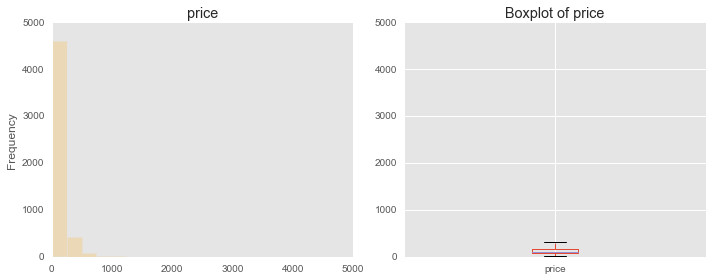

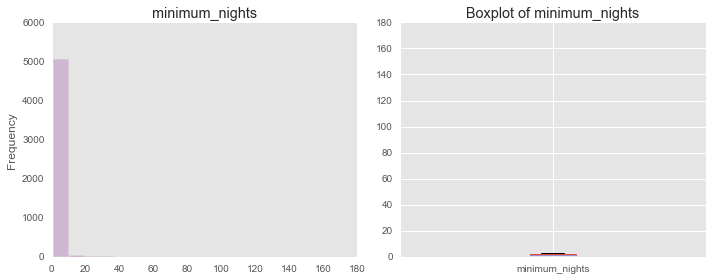

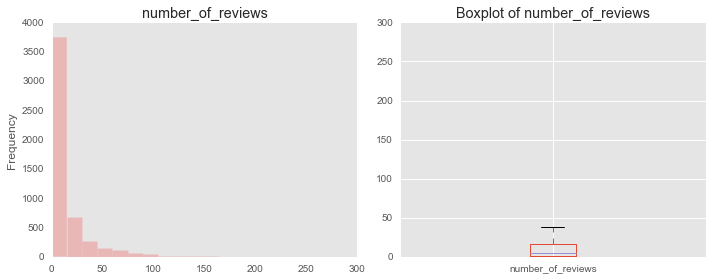

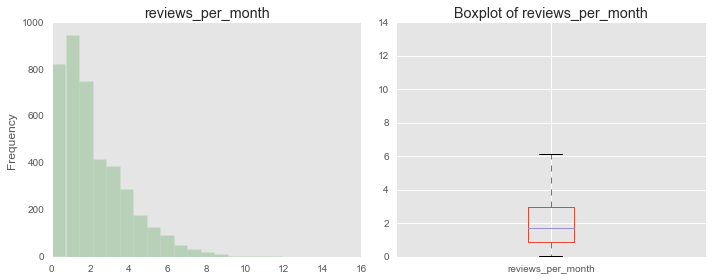

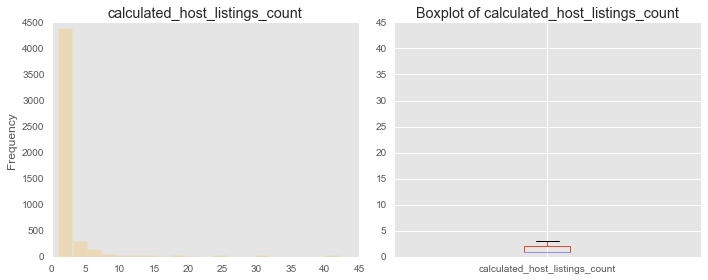

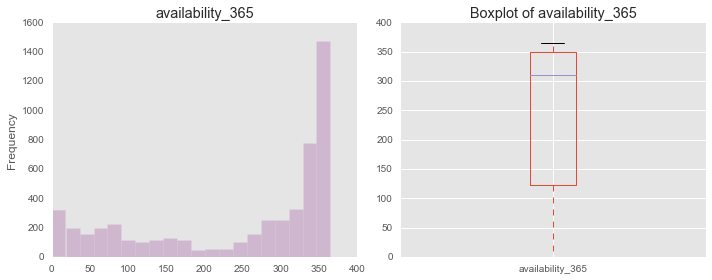

In [58]:
create_hist_box(chicago_listing,all_cols,['id','name','host_name','neighbourhood_group','neighbourhood','room_type','latitude','longitude','room_type','last_review'])

In [60]:
chicago_listing.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1874928,Sunny 2Bd 1Ba HEART of LINCOLN SQ.!,9767449,Rick And Suzanne,NaN,Lincoln Square,41.965926,-87.683117,Entire home/apt,142,2,34,2015-09-22,2.71,1,144
1,739495,Lovely 2 bedroom in Lincoln Square,3867687,Janet,NaN,Lincoln Square,41.977993,-87.681208,Entire home/apt,120,3,61,2015-09-22,2.27,1,134


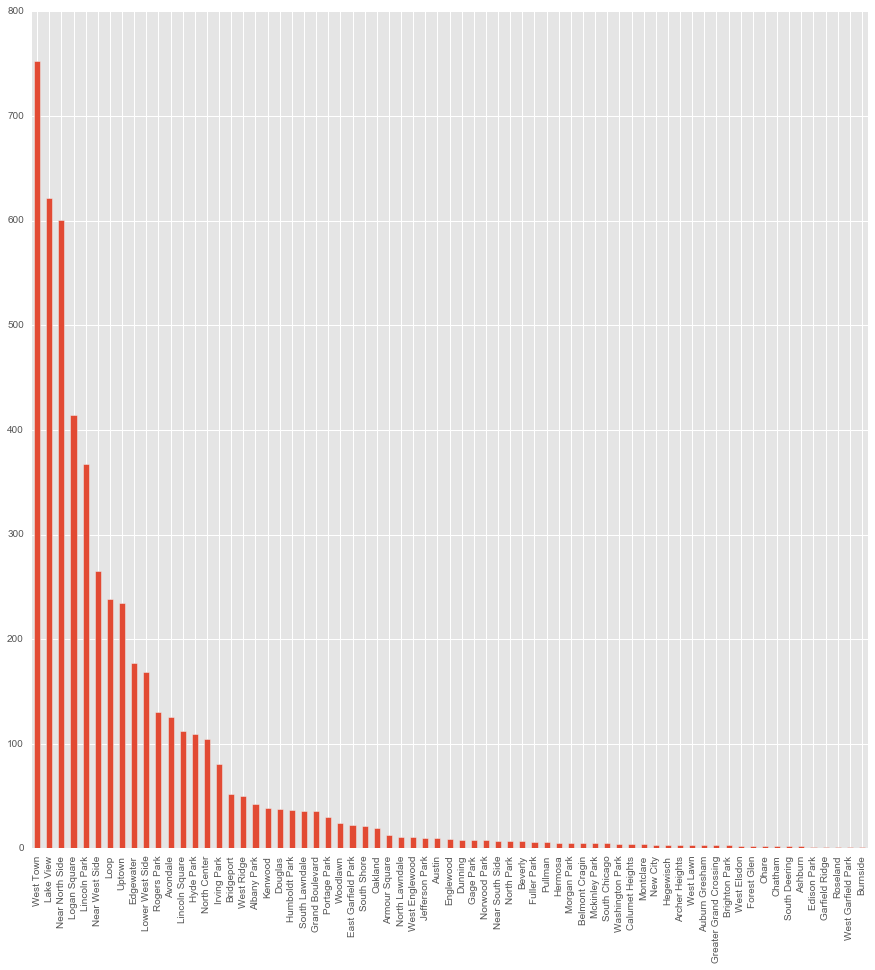

In [92]:
n_hoods = [(row[0]) for row in chicago_listing.neighbourhood.value_counts().to_frame().iterrows()]

fig, ax = plt.subplots(1,1) 

chicago_listing.neighbourhood.value_counts().plot(kind='bar', figsize=(15,15))

ax.set_xticklabels(n_hoods,rotation='vertical')
plt.show()

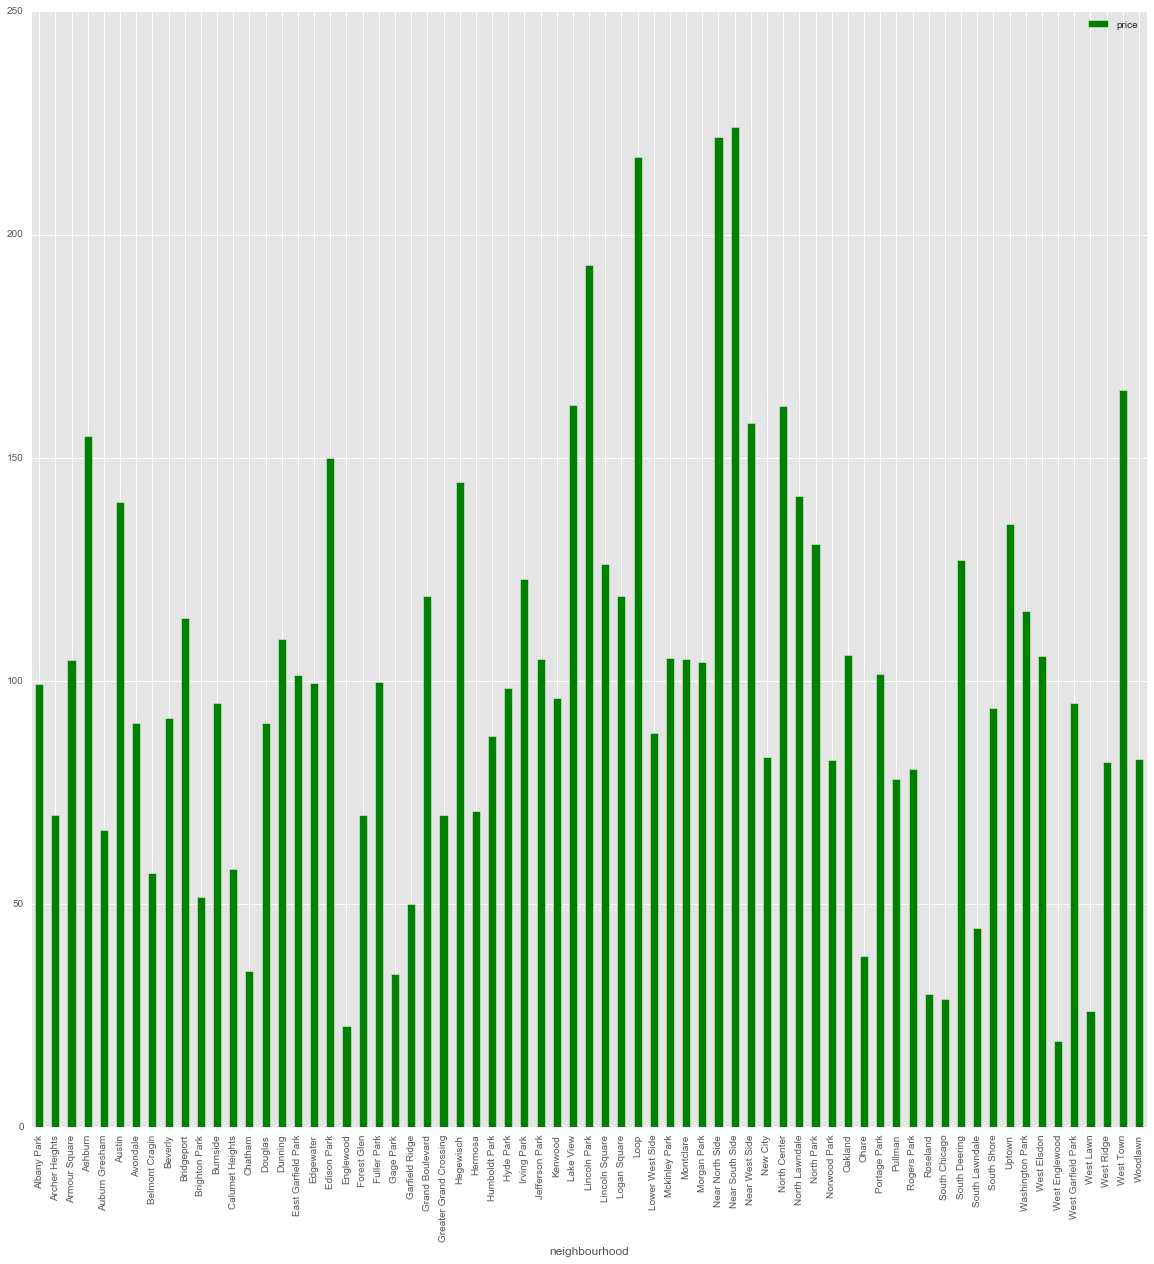

In [53]:
neighborhoods = chicago_listing[['neighbourhood','price']]
neighborhoods.groupby('neighbourhood').mean().plot(kind='bar', figsize=(20,20),color = 'green')
#plt.xticks(range(0,1500,50), rotation=70)
#plt.xlim(0,1500,25)

In [11]:
fname = 'data/Boundaries - ZIP Codes.geojson'
chicago = gpd.read_file(fname)
chicago.head()

,geometry,objectid,shape_area,shape_len,zip
0,(POLYGON ((-87.67762151065281 41.9177578010629...,33,106052287.488,42720.0444058,60647
1,(POLYGON ((-87.72683253163021 41.9226462671259...,34,127476050.762,48103.7827213,60639
2,(POLYGON ((-87.78500237831095 41.9091478547167...,35,45069038.4783,27288.6096123,60707
3,(POLYGON ((-87.6670686895295 41.88885188496992...,36,70853834.3797,42527.9896789,60622
4,(POLYGON ((-87.70655631674127 41.8955534069940...,37,99039621.2518,47970.1401531,60651


/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


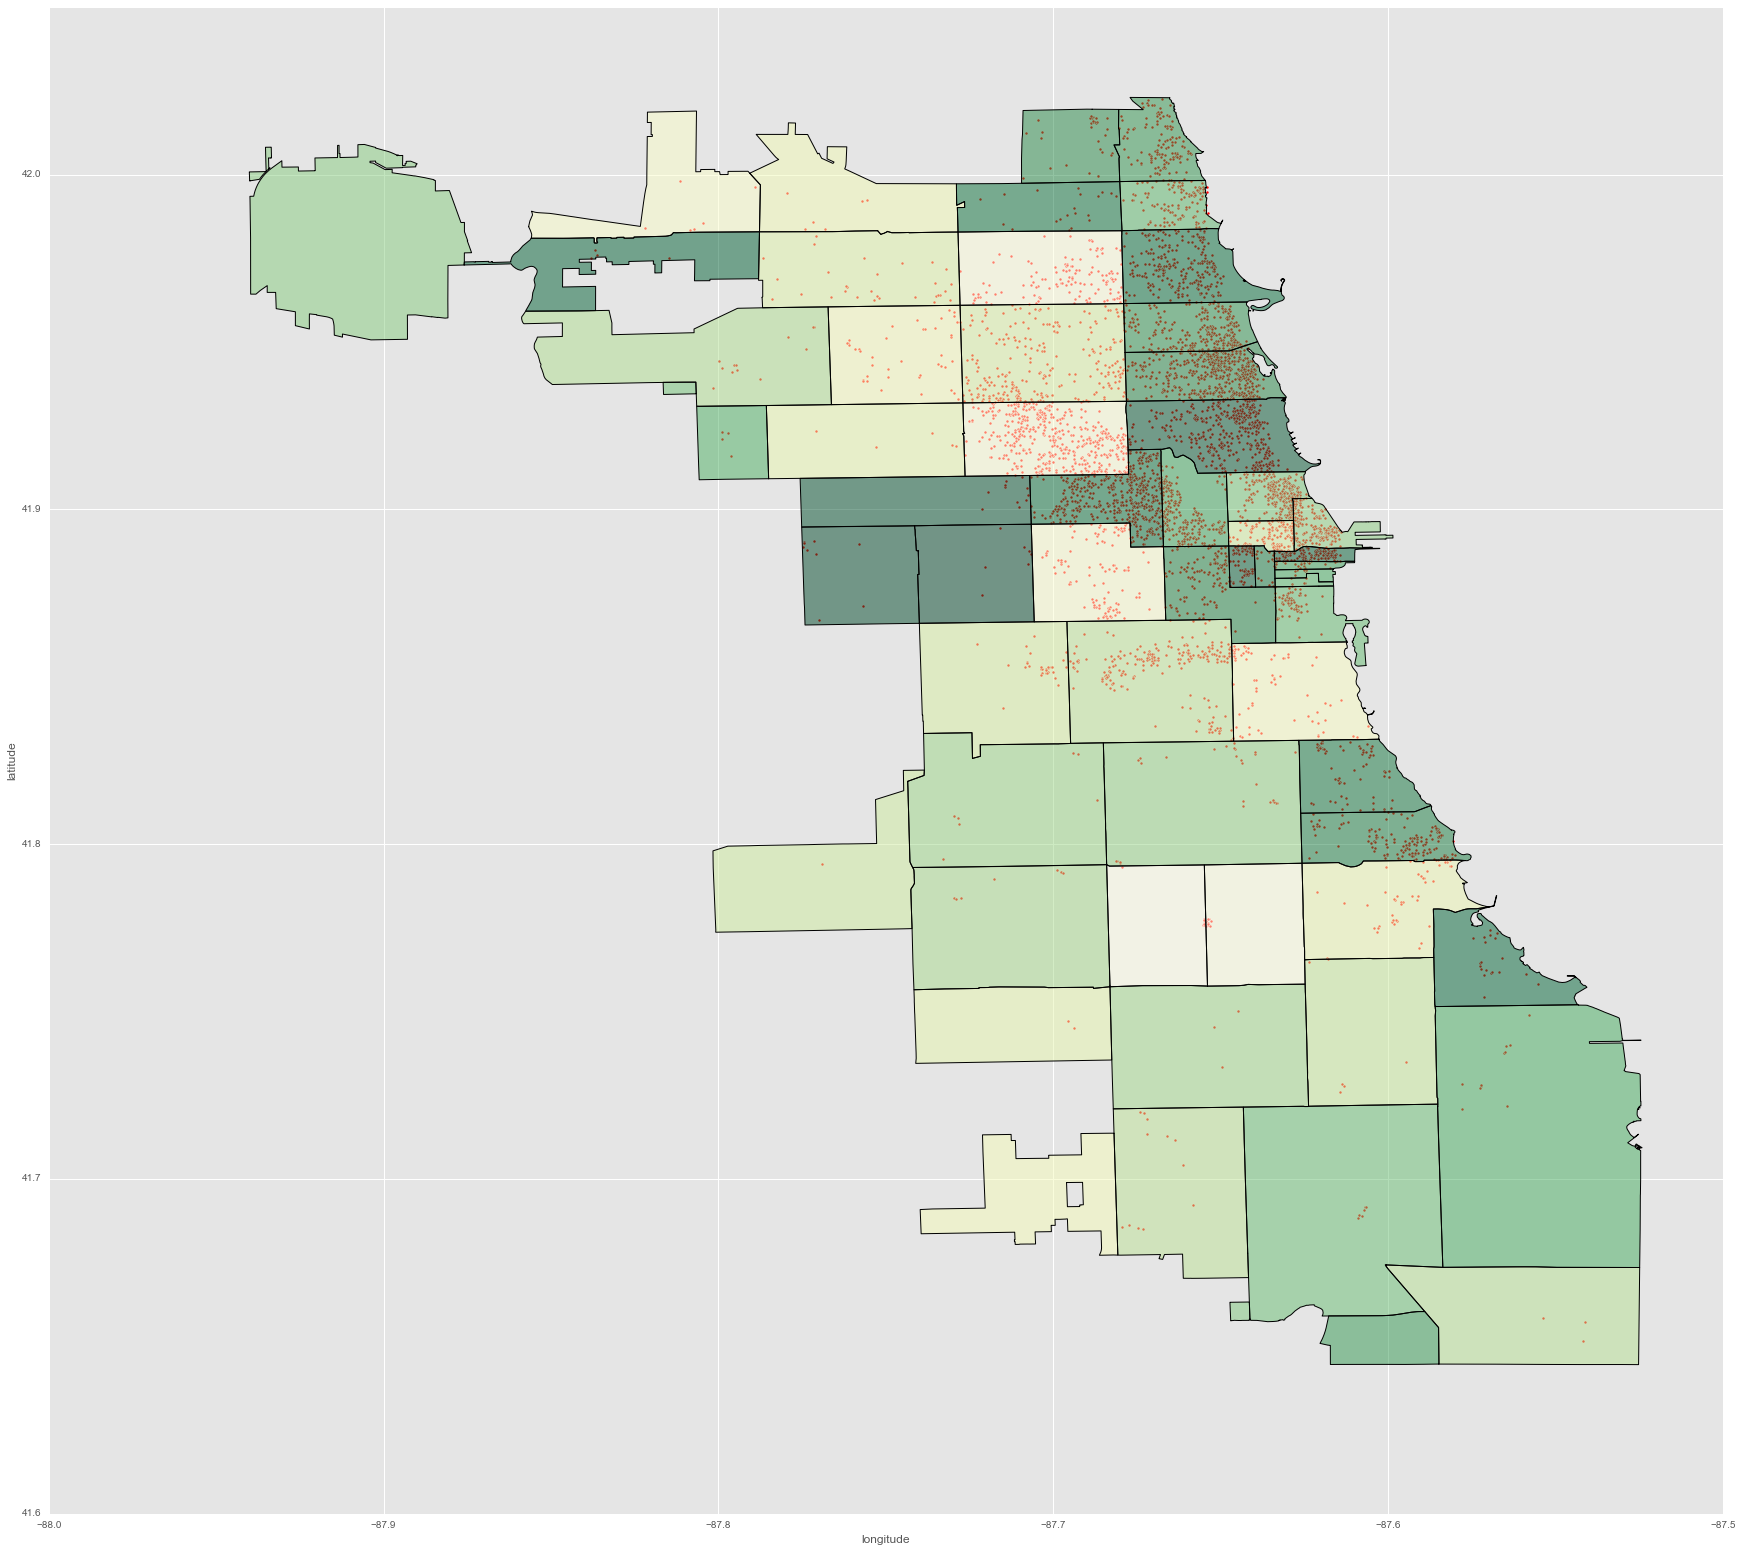

In [34]:
base = chicago.plot(column='shape_area', colormap='YlGn', figsize=(30,30))
chicago_listing.plot(ax=base,kind='scatter', x='longitude', y='latitude', figsize=(30,30), s=9, c='red')

In [35]:
check_na(chicago_listing)

value,False,True
variable,,
availability_365,5147,0
calculated_host_listings_count,5147,0
host_id,5147,0
host_name,5109,38
id,5147,0
last_review,4142,1005
latitude,5147,0
longitude,5147,0
minimum_nights,5147,0
